# ![](https://ga-dash.s3.amazonaws.com/production/assets/logo-9f88ae6c9c3871690e33280fcf557f33.png) Autocorrelation & Time Series Data
Week 12 | Lesson 1.2



### LEARNING OBJECTIVES

*After this lesson, you will be able to:*
- Explain the components of time series data
- Explain autocorrelation from mathematical, technological and practical perspectives
- Measure autocorrelation in Pandas

### LESSON GUIDE
| TIMING  | TYPE  | TOPIC  |
|:-:|---|---|
| 5 min  | [Opening](#opening)  | Time series  |
| 15 min  | [Introduction](#intro-trend-season)   | Trend and Seasonality  |
| 65 min  | [Demo/Codealong](#demo-autocor)  | Autocorrelation  |
| 5 min  | [Conclusion](#conclusion)  | Topic description  |

---



<a name="opening"></a>
## Opening (5 mins)

> **Check** What are some real world scenarios where time series data analysis is useful?



In this lesson, we will discuss statistics associated with data that change over time, and how to analyze that change. Key concepts include:

- Trends
- Seasonality
- Autocorrelation

Tomorrow we introduce ARIMA models, which integrate some of these components to do forecasting.

<a name="intro-trend-season"></a>
## Introduction: Trend and Seasonality (15 mins)

**QUESTION:** What constitutes a trend in data? Is linearity required for trend?

- A trend is any long-term change in the value we're measuring. Trends may “change direction”, going from an increasing trend to a decreasing trend.

- Trend can only be measured in the scope of the data collected; there may be trends that are unmeasureable if the data are not complete.

An example of an upward trend:
![](./assets/images/trend-line2.png)


When patterns repeat over *known, fixed periods* of time within the data set, we call this **seasonality**.

A seasonal pattern exists when a series is influenced by factors relating to the cyclic nature of time - i.e. time of month, quarter, year, etc. Seasonality is of a fixed and known period, otherwise it is not truly seasonality, and must be either attributed to another factor or counted as a set of anomalous events in the data.

![](./assets/images/seasonality_decreasing_trend.png)

The easiest way to visualize trends is by drawing trend lines. Please open the [trendlines](./w12d1-trendline-codealong-workbook.ipynb) notebook for this demonstration.

<a name="demo-autocor"></a>
## Demo/Codealong: Autocorrelation (65 mins)

#### What is Autocorrelation?

While in previous weeks, our analyses has been concerned with the correlation between two or more variables (height and weight, education and salary, etc.), in time series data, autocorrelation is a measure of _how correlated a variable is with itself_.

Specifically, autocorrelation measures how closely related earlier values are with values occurring later in time.

#### How do we compute Autocorrelation?


${\Huge R(k) = \frac{\operatorname{E}[(X_{t} - \mu)(X_{t-k} - \mu)]}{\sigma^2}}^*$

To compute autocorrelation, we fix a lag _k_ which is the delta between the given point and the prior point used to compute the [correlation](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient).

With a _k_ value of 1, we'd compute how correlated a value is with the prior one. With a _k_ value of 10, we'd compute how correlated a variable is with one 10 time points earlier.

$^*$ Note that this formula assumes *stationarity*, which we'll talk about tomorrow.

#### Codealong

We will be using data made available by a German drugstore, Rossmann. This data contains the daily sales made at the drugstore as well as whether a sale or holiday affected the sales data.

Please open the [autocorrelation](./w12d1-autocorrelation-codealong-workbook.ipynb) notebook.



#### Loading the data

As with previous datasets, we can use Pandas to load our data:

```python
import pandas as pd

data = pd.read_csv('assets/datasets/rossmann.csv', skipinitialspace=True)
```

Because we are most interested in the `Date` column (which contains the date of sales for each store), we will make sure to process that as a `DateTime` type, and make it the index of our dataframe.

```python

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month
```

This allows us to easily filter by date as well. For example, we can filter to a particular year:

```python
data['2014']
```

Or to a particular month:

```python
data['2015-05']
```

There are over a million sales data points in this dataset, so for some simple EDA we will focus on just one store.

```python
store1_data = data[data.Store == 1]
```

#### Plotting the sales data

We want to know both the time dependent elements of sales as well as whether promotions or holidays affected these sales. To start, we can compare the average sales on those events.

To compare sales on holidays, we can compare the sales using box-plots, which allows us to compare the distribution of sales on holidays against all other days. On state holidays the store is closed (which means there are 0 sales), and on school holidays the sales are relatively similar. These types of insights represent the contextual knowledge needed to truly explain time series phenomenon.

> Check: can you think of any other special considerations we should make when tracking sales?



```python
sb.factorplot(
    x='SchoolHoliday',
    y='Sales',
    data=store1_data[store1_data.Open==1],
    kind='box'
)
```

**Check:** Now check to see if there is a difference affecting sales on promotion days.

We can see that there _is_ a difference in sales on promotion days.

```python
sb.factorplot(
    col='Open',
    x='Promo',
    y='Sales',
    data=store1_data,
    kind='box'
)
```

Why is it important to separate out days where the store is closed? Because there aren't any promotions on those days either, so including them will bias your sales data on days without promotions! Remember to think about the business logic as well as analyzing the raw data.

We may also want to compare sales across days of the week:

```python
sb.factorplot(
    col='Open',
    x='DayOfWeek',
    y='Sales',
    data=store1_data,
    kind='box',

)
```


Lastly, we want to identify larger-scale trends in our data. How did sales change from 2014 to 2015? Were there any particularly interesting outliers in terms of sales or customer visits?

To plot the sales over time:

```python
# Filter to days store 1 was open
store1_open_data = store1_data[store1_data.Open==1]
store1_open_data[['Sales']].plot()
```

To plot the customer visits over time:

```python
store1_open_data[['Customers']].plot()
```

We can see that there are large spikes of sales and customers towards the end of 2013 and 2014, leading into the first quarter of 2014 and 2015.

**Check:** Use the index filtering to filter just to 2015 changes over time. This should make it easier to identify the holiday sales bump.

```python
store1_data_2015 = store1_data['2015']
store1_data_2015[
    store1_data_2015.Open==1
][['Sales']].plot()
```

#### Computing Autocorrelation

To measure how much the sales are correlated with each other, we want to compute the _autocorrelation_ of the 'Sales' column.

Pandas' `autocorr` function takes one argument, `lag` - how many prior data points to use to compute the correlation. If we set the `lag` to 1, we compute the correlation between every point and the point directly preceding it. Setting `lag` to 10 would computes the correlation between every point and the point 10 days earlier.



```python
data['Sales'].resample('D', how='mean').autocorr(lag=1)
```

Just like with correlation between different variables, the data becomes more correlated as this number moves closer to 1.

**Check:** What does the autocorrelation values of Sales and Customers imply about our data?

#### Aggregates of sales over time

If we want to investigate trends over time in sales, as always, we will start by computing simple aggregates. We want to know: what were the mean and median sales in each month and year?

We can use `data.resample` and provide as arguments:
    - The level on which to roll-up to, 'D' for day, 'W' for week, 'M' for month, 'A' for year
    - The aggregation to perform: 'mean', 'median', 'sum', etc.

```python
data[['Sales']].resample('A', how=['median', 'mean'])

data[['Sales']].resample('M', how=['median', 'mean'])
```

Here we can see again that December 2013 and 2014 were the highest average sale months.

While identifying monthly averages is useful, we often want to compare the sales data of a date to a smaller window. To understand holidays sales, we don't want to compare sales data in late December with the entire month, but instead to a few days immediately surrounding it. We can do this using rolling averages.

In pandas, we can compute rolling average using the `pd.rolling_mean` or `pd.rolling_median` functions.

```python
# Resample to have the daily total over all stores
daily_store_sales = data[['Sales']].resample('D', how='sum')
pd.rolling_mean(daily_store_sales, window=3, center=True)
```

This computes a rolling mean of sales using the sales on each day, the day preceding and the day following (window = 3, center=True).

`rolling_mean` (as well as `rolling_median`) takes the series to aggregate as well as three important parameters:
    - `window` is the number of days to include in the average
    - `center` is whether the window should be centered on the date or use data prior to that date

You may first want to `resample` or group your data by a time-period. For example, our data is on a daily level by store, so may first want to average over stores. We can use `D` for day, `M` for month or `A` for year to average the values by those timeperiods.




We can use our index filtering to just look at 2015.

```python
pd.rolling_mean(daily_store_sales, window=3, center=True)['2015']
```




Instead of plotting the full time series, we can plot the rolling mean instead, which smooths random changes in sales as well as removing outliers, helping us identify larger trends.

```python
pd.rolling_mean(daily_store_sales, window=10, center=True).plot()
```



In [8]:
import pandas as pd
import matplotlib as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 10.0)

data = pd.read_csv('./assets/datasets/rossmann.csv', skipinitialspace=True, low_memory=False)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Year'] = data.index.year
data['Month'] = data.index.month

daily_store_sales = data[['Sales']].resample('D', how='sum')


/Users/winston/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()


In [23]:
data.head()

Store  DayOfWeek  Sales  Customers  Open  Promo StateHoliday  \
Date                                                                       
2015-07-31      1          5   5263        555     1      1            0   
2015-07-31      2          5   6064        625     1      1            0   
2015-07-31      3          5   8314        821     1      1            0   
2015-07-31      4          5  13995       1498     1      1            0   
2015-07-31      5          5   4822        559     1      1            0   

            SchoolHoliday  Year  Month  
Date                                    
2015-07-31              1  2015      7  
2015-07-31              1  2015      7  
2015-07-31              1  2015      7  
2015-07-31              1  2015      7  
2015-07-31              1  2015      7

/Users/winston/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=10,center=True).mean()
  if __name__ == '__main__':


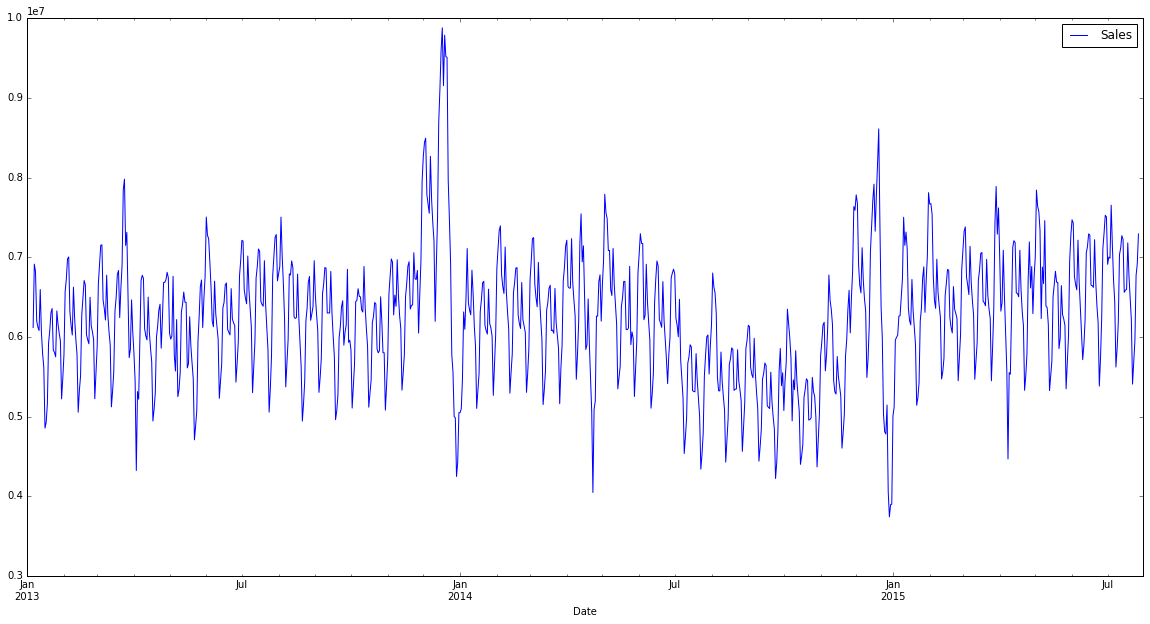

In [11]:
pd.rolling_mean(daily_store_sales, window=10, center=True).plot()

As we discussed earlier, this averages all values in the window evenly, but we might want to weight closer values more. For example, with a centered weighted average of 10 days, we want to put additional emphasis on +/- 1 day versus +/- 10 days. One option to do that is the `ewma` function or `exponential weighted moving average` function.

```python
pd.ewma(daily_store_sales, span=10)
```

/Users/winston/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: pd.ewm_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.ewm(ignore_na=False,span=10,min_periods=0,adjust=True).mean()
  if __name__ == '__main__':


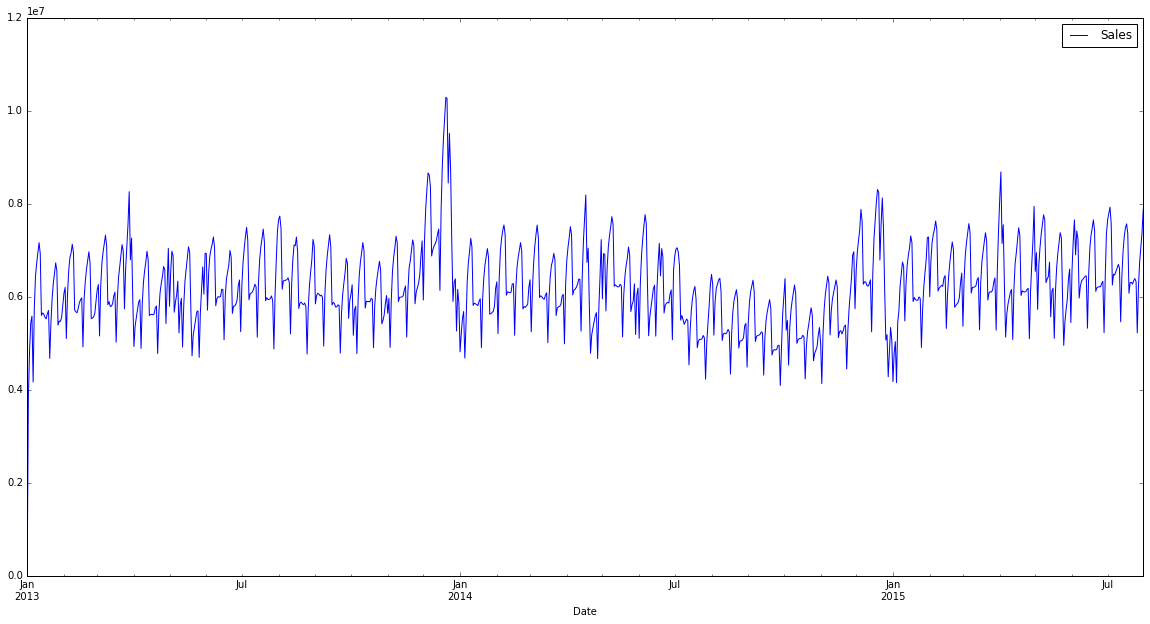

In [24]:
pd.ewma(daily_store_sales, span=10).plot()

**Check:** Discuss the differences in the plot between the 10-day moving average and the 10 day exponentially weighted moving average.

#### Pandas Window functions

Pandas `rolling_mean` and `rolling_median` are only two examples of Pandas window function capabilities. Window functions operate on a set of N consecutive rows (i.e.: a window) and produce an output.

In addition to `rolling_mean` and `rolling_median`, there are `rolling_sum`, `rolling_min`, `rolling_max`... and many more.

Another common one is `diff`, which takes the difference over time. `pd.diff` takes one argument: `periods`, which measures how many rows prior to use for the difference.

For example, if we want to compute the difference in sales, day by day, we could compute:

```python
daily_store_sales.diff(periods=1)
```

However, if wanted to compare the same day the prior week, we could set `periods=7`

```python
daily_store_sales.diff(periods=7)
```

This would compute the difference in sales from every day to the same day in a previous week. **Difference functions** allow us to identify seasonal changes when we see repeated up or downswings.




The following plot of the month to month change (`diff`) in jobs from FiveThirtyEight helps identify the seasonal component to a number of retail jobs:

![](./assets/images/casselman-datalab-wsj2.png)


#### Pandas Expanding Functions

In addition to the set of `rolling_*` functions, Pandas also provides a similar collection of `expanding_*` functions, which, instead of using a window of N values, uses all values up until that time.

For example,

```python
pd.expanding_mean(daily_store_sales)
```

computes the average sales, from the first date _until_ the date specified. Meanwhile:

```python
pd.expanding_sum(daily_store_sales)
```

computes the sum of average sales per store up until that date.




<a name="ind-practice"></a>

### Independent practice

1. Plot the distribution of sales by month and compare the effect of promotions.
2. Are sales more correlated with the prior date, a similar date last year, or a similar date last month?
3. Plot the 15 day rolling mean of customers in the stores.
4. Identify the date with largest drop in sales from the same date in the previous month.
5. Compute the total sales up until Dec. 2014.
6. When were the largest differences between 15-day moving/rolling averages? HINT: Using `rolling_mean` and `diff`




<a name="ind-practice-review"></a>

1. Plot the distribution of sales by month and compare the effect of promotions

```python
sb.factorplot(
    col='Open',
    hue='Promo',
    x='Month',
    y='Sales',
    data=store1_data,
    kind='box'
)
```





2. Are sales more correlated with the prior date, a similar date last year, or a similar date last month?

```python
# Compare the following:
average_daily_sales = data[['Sales', 'Open']].resample('D', how='mean')

average_daily_sales['Sales'].autocorr(lag=1)

average_daily_sales['Sales'].autocorr(lag=30)

average_daily_sales['Sales'].autocorr(lag=365)
```




3. Plot the 15 day rolling mean of customers in the stores:

```python
pd.rolling_mean(data[['Sales']], window=15, freq='D').plot()
```



4. Identify the date with largest drop in average store sales from the same date in the previous month:

```python
average_daily_sales = data[['Sales', 'Open']].resample('D', how='mean')
average_daily_sales['DiffVsLastWeek'] = average_daily_sales[['Sales']].diff(periods=7)

average_daily_sales.sort(['DiffVsLastWeek']).head
```

Unsurprisingly, this day is Dec. 25 and Dec. 26 in 2014 and 2015, when the store is closed and there are many sales in the preceding week. How about when the store is open?

```python
average_daily_sales[average_daily_sales.Open == 1].sort(['DiffVsLastWeek'])
```

The top values are Dec. 24th, but sales on 2013-12-09 and 2013-10-14 were on average 4k lower than the same day in the previous week.




5. Compute the total sales up until Dec. 2014:

```python
total_daily_sales = data[['Sales']].resample('D', how='sum')
pd.expanding_sum(total_daily_sales)['2014-12']
```

Note that this is **NOT**

```python
pd.expanding_sum(data['Sales'])['2014-12']
```

because we do **not** want to sum over our stores first.



6. When were the largest differences between 15-day moving/rolling averages?
HINT: Using `rolling_mean` and `diff`

```python
pd.rolling_mean(total_daily_sales, window=15).diff(1).sort('Sales')
```

Unsurprisingly, they occur at the beginning of every year after the holiday season.

<a name="conclusion"></a>
## Conclusion (5 mins)
- We use time series analysis to identify changes in values over time
- We want to identify whether changes are true trends, seasonal changes or something else
- Autocorrelations are a measure of how much a data point is dependent on previous data points
- Rolling means give us a local statistic of an average in time, smoothing out random fluctuations and removing outliers